<a href="https://colab.research.google.com/github/jagadeesh-usd/receipt-expense-tracker-cv/blob/jaga-dev/notebooks/09_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Automated Expense Extraction - Receipt Parsing Using YOLO and OCR
### Hybrid Inference Application  

### Objective
Demonstrate the end-to-end **Hybrid "Safety Net" Architecture** on real-world data. This notebook acts as the final application layer, integrating the trained Vision Model (YOLOv8), Context-Aware Preprocessing, and Algorithmic Fallbacks into a single robust pipeline.

### System Architecture
The pipeline executes the following decision logic for every input image:

1.  **Source Classification:**
    * Analyzes image statistics (Brightness/Contrast) to detect if the input is a **Clean Scan** (SROIE) or a **Mobile Photo** (Shadowed).
    * **Action:** Switches preprocessing modes automatically (`Adaptive Thresholding` vs. `Morphological Shadow Removal`).

2.  **Visual Localization (YOLOv8):**
    * Detects Regions of Interest (ROI) for **Vendor**, **Date**, and **Total**.
    * Ignores background noise, ads, and irrelevant text.

3.  **Smart Extraction (OCR):**
    * Applies class-specific cleaning to crops (e.g., preserving logo shapes for Vendors, aggressively thresholding digits for Totals).
    * Runs Tesseract OCR on the optimized crops.

4.  **The "Safety Net" (Fallback Layer):**
    * **Trigger:** If YOLO fails to detect a field (e.g., Date) OR if the extracted text fails Regex validation.
    * **Response:** Reverts to a "Full Page Scan" using algorithmic search to recover the missing data.

### Output
* **Visual Visualization:** Displays the image with bounding boxes (Green = YOLO detections).
* **Console Logs:** Prints decision trails (e.g., `YOLO missed Date... Safety Net Rescued Date`), proving the system's resilience.

In [1]:
# Install Dependencies
!pip install ultralytics pytesseract
# !sudo apt-get install tesseract-ocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.2 MB/s eta 0:00:00


#### Setup & Configuration

In [2]:
import cv2
import numpy as np
import pytesseract
import matplotlib.pyplot as plt
from ultralytics import YOLO
from pathlib import Path
from PIL import Image
import re
import os

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
# Check if running in Google Colab
if 'COLAB_GPU' in os.environ:
    # Mount Google Drive (for Colab)
    from google.colab import drive
    drive.mount('/content/drive')

    # Set DATA_PATH for Google Drive
    DATA_PATH = Path('/content/drive/MyDrive/data')
else:
    # Set DATA_PATH for local environment
    DATA_PATH = Path('../data')

Mounted at /content/drive


#### Load trained model

In [4]:
# model_path = DATA_PATH / "models/yolo_receipts/weights/best.pt"
# model_path = DATA_PATH / "models/yolo_receipts_small/weights/best.pt"
model_path = DATA_PATH / "models/yolo_receipts_highres_nano/weights/best.pt"
model = YOLO(model_path)

#### Adaptive Preprocessing

In [5]:
def clean_crop_vendor(crop_img):
    """Gentle cleaning for Logos (Grayscale + Median Blur)"""
    if len(crop_img.shape) == 3: gray = cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY)
    else: gray = crop_img
    gray = cv2.resize(gray, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
    return cv2.medianBlur(gray, 3)

def clean_crop_numeric(crop_img):
    """Aggressive cleaning for Numbers (Adaptive Threshold)"""
    if len(crop_img.shape) == 3: gray = cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY)
    else: gray = crop_img
    gray = cv2.resize(gray, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    return cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 10)

def preprocess_full_page(original_img):
    """
    UNIVERSAL CLEANER: Handles both Scans (SROIE) and Mobile Photos.
    1. Removes Scanner Borders.
    2. Adaptive Thresholding (Best for text).
    """
    # 1. Convert to Gray
    if len(original_img.shape) == 3:
        gray = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
    else:
        gray = original_img

    # 2. Resize (Standardize)
    h, w = gray.shape
    scale = 1000 / h
    gray = cv2.resize(gray, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)

    # 3. Gaussian Blur (Kill sensor noise)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # 4. Morphological Open (Remove thin lines/noise)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
    gray = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel)

    # 5. Adaptive Thresholding (The Robust Standard)
    # We use a large block size (31) to handle shadows if they exist,
    # but it works perfectly on flat white scans too.
    thresh = cv2.adaptiveThreshold(
        gray, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,
        31, 10
    )

    # 6. BORDER REMOVAL (Crucial for Scans)
    # Finds the largest connected component (the receipt) and blacks out the rest
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_cnt = max(contours, key=cv2.contourArea)
        mask = np.zeros_like(thresh)
        cv2.drawContours(mask, [largest_cnt], -1, 255, -1)
        # Apply mask: Keep only the receipt, make everything else white
        result = cv2.bitwise_and(thresh, thresh, mask=mask)
        # Invert mask to make background white (Tesseract loves white backgrounds)
        background = cv2.bitwise_not(mask)
        result = cv2.add(result, background)
        return result

    return thresh

#### Universal Fallback Logic

In [6]:

def fallback_find_total(text):
    """
    Finds currency.
    IMPROVEMENT: Uses \b to force stop after 2 decimals.
    Handles 9.00, 1,200.50, 9,00 (European style)
    """
    # Regex:
    # \d{1,3}       -> 1 to 3 digits
    # (?:[.,]\d{3})* -> Optional thousands separators
    # [.,]          -> Decimal point (dot or comma)
    # \d{2}         -> EXACTLY two decimals
    # \b            -> Word boundary (Stops 9.006 from becoming 9.006)
    pattern = r'(\d{1,3}(?:[.,]\d{3})*[.,]\d{2})\b'

    matches = re.findall(pattern, text)
    if not matches: return None

    try:
        # Clean standard: replace , with . if it looks like a decimal
        # Heuristic: The largest number is usually the Total
        clean_values = []
        for m in matches:
            # Normalize 1,200.00 -> 1200.00
            # Normalize 9,00 -> 9.00
            val = m.replace(',', '.')
            # Fix double dots if any
            if val.count('.') > 1: val = val.replace('.', '', val.count('.')-1)
            clean_values.append(float(val))

        return "{:.2f}".format(max(clean_values))
    except:
        return matches[-1]

def fallback_find_vendor(text):
    """
    Heuristic: Vendor is the first SIGNIFICANT line.
    IMPROVEMENT: Skips lines that are too short (< 4 chars).
    """
    # Split into lines and remove empty ones
    lines = [line.strip() for line in text.split('\n') if len(line.strip()) > 0]

    blacklist = ["welcome", "receipt", "tax invoice", "gst", "tel", "fax", "website", "email"]

    for line in lines[:6]: # Check top 6 lines
        # Rule 1: Must be longer than 3 chars ("NH" -> Skip)
        if len(line) < 4: continue

        # Rule 2: Must not contain blacklist words
        if not any(b in line.lower() for b in blacklist):
            # Rule 3: Must generally look like a name (mostly letters)
            # (Optional check to avoid pure numbers being picked as vendor)
            if any(c.isalpha() for c in line):
                return line
    return None

def get_full_page_text(original_img):
    """Debug wrapper for OCR"""
    print(" Running Full Page OCR Safety Net...")
    processed = preprocess_full_page(original_img)

    # DEBUG: See what the safety net sees!
    plt.figure(figsize=(6,6)); plt.imshow(processed, cmap='gray'); plt.title("Safety Net Input"); plt.show()

    text = pytesseract.image_to_string(processed, config='--psm 3')

    # DEBUG: Print the text to console so you can see why it failed
    # print(f"--- FULL PAGE TEXT DUMP ---\n{text}\n---------------------------")

    return text


def fallback_find_date(text):
    """Finds date patterns in full text"""
    # Matches: 25/12/2018, 2018-12-25, 25 DEC 2018
    pattern = r'(\d{1,2}[/-]\d{1,2}[/-]\d{2,4}|\d{4}[/-]\d{1,2}[/-]\d{1,2}|\d{1,2}\s(?:JAN|FEB|MAR|APR|MAY|JUN|JUL|AUG|SEP|OCT|NOV|DEC)[a-z]*\s\d{2,4})'
    matches = re.findall(pattern, text, re.IGNORECASE)
    return matches[0] if matches else None


#### Main Inference Pipeline

In [7]:
def run_scanner(image_path):
    print(f"\n--- 📸 Scanning: {image_path.name} ---")

    # 1. VISUAL DETECTION (YOLO)
    results = model.predict(image_path, conf=0.10, verbose=False)
    result = results[0]
    original_img = cv2.imread(str(image_path))
    display_img = cv2.cvtColor(original_img.copy(), cv2.COLOR_BGR2RGB)

    extracted_data = {}

    # 2. PROCESS YOLO HITS
    for box in result.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        cls_id = int(box.cls[0])
        label = model.names[cls_id]

        # Crop & Clean
        h, w, _ = original_img.shape
        crop = original_img[max(0, y1-5):min(h, y2+5), max(0, x1-5):min(w, x2+5)]
        if crop.size == 0: continue

        if label in ['company', 'vendor']:
            final_crop = clean_crop_vendor(crop)
            config = '--psm 6'
        else:
            final_crop = clean_crop_numeric(crop)
            config = '--psm 7 -c tessedit_char_whitelist=0123456789./:-RM'

        text = pytesseract.image_to_string(final_crop, config=config).strip()
        if label == 'total': text = text.replace("RP", "RM").replace("Rm", "RM")

        # Store (Keep first detection)
        if label not in extracted_data:
            extracted_data[label] = text

        # Visualization
        cv2.rectangle(display_img, (x1, y1), (x2, y2), (0, 255, 0), 3)
        cv2.putText(display_img, f"{label}: {text}", (x1, y1-10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # UNIVERSAL SAFETY NET (Check ALL fields)
    required_fields = ['vendor', 'date', 'total']

    # Check if we are missing ANY field
    if 'company' in extracted_data: extracted_data['vendor'] = extracted_data.pop('company')

    missing_fields = [f for f in required_fields if f not in extracted_data]

    if missing_fields:
        print(f"   ⚠️ Missing fields: {missing_fields}. Engaging Fallback...")

        # Run OCR ONCE on full page
        full_text = get_full_page_text(original_img)
        print(full_text)

        if 'date' in missing_fields:
            val = fallback_find_date(full_text)
            if val: extracted_data['date'] = val

        if 'total' in missing_fields:
            val = fallback_find_total(full_text)
            if val: extracted_data['total'] = val

        if 'vendor' in missing_fields:
            val = fallback_find_vendor(full_text)
            if val: extracted_data['vendor'] = val

    # 4. DISPLAY
    plt.figure(figsize=(10, 10))
    plt.imshow(display_img)
    plt.axis('off')
    plt.title("YOLO + Hybrid Fallback", fontsize=14)
    plt.show()

    print("\n--- 🧾 EXTRACTED DATA ---")
    for k, v in extracted_data.items():
        print(f"  {k.upper()}: {v}")
    print("-" * 30)


--- 📸 Scanning: X51006387931.jpg ---
   ⚠️ Missing fields: ['vendor', 'date']. Engaging Fallback...
 Running Full Page OCR Safety Net...


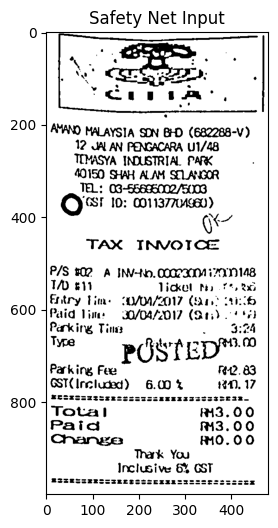

 

AMANO MALAYSIA SON BHD (682288-V)
12 JALAN PENGACARA U1/48
TOMASYA INDUSTRIAL PARK
40150 SHAH ALAM SCLANGOR

TEL: 03-66606002/5003
oO: 10: 001137704980)
“
TAX INVOTCE
P/S #02 A INV-No.cooeaom N48
TA 811 Ticket No 0%, 3G

Entry Time “0/04/2017 (gat ti
Paid lime: = SO/04&/20017 (S43) 4 4}

Parking Tins . 3:04
Type P OST Ep ©
Parking Fee 442.83
GST(Ireluded) 6.00 & 1), 17
Total  —s«H3..00
Paid 13.00
Change H10.00
Thak You

Inclusive 6% GST

B2URSTRRSSzeerssscxrzz=:

 



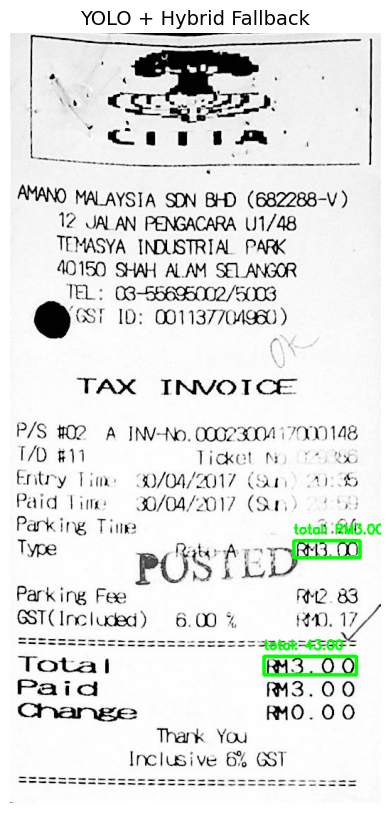


--- 🧾 EXTRACTED DATA ---
  TOTAL: 43.00
  DATE: 0/04/2017
  VENDOR: AMANO MALAYSIA SON BHD (682288-V)
------------------------------

--- 📸 Scanning: X51005675914.jpg ---
   ⚠️ Missing fields: ['date']. Engaging Fallback...
 Running Full Page OCR Safety Net...


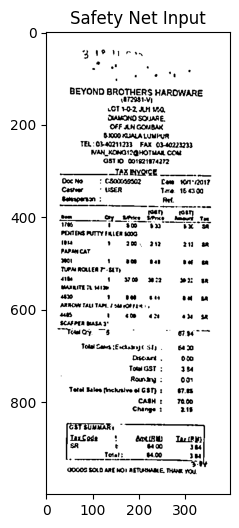

BVP ry
.

BEYOND BROTHERS HAROWARE
T2814)

.0T 10-2 AM 140,
OUMOHO SQUARE,
OFF AH GOUBAK
8.3000 KUALA LUMPUR
TEL :0340211232 Fax 03-40223713.
WAN_KONGI2QHOTMARL COM
GSTIO co1eztE7azT2

TAR VOCE

 

(oc No 1 G§00059s02 Com wri20r

 

 

Coser * USER Tre. 16.00
ea
a
PENTEMS PUTTY FALLEN $000
(mua y 2m, aR 20a
PAPA CAT
mo ‘ a” on 1;
TURN ROULER -S17)
ae 1 97000 wt ata
watt a wie
“7. 1 ne it ta
ARMOWS TAL TAM, Fa eo PE
as 1 ete oan Mom
‘SCAFPER Basa 3°
Yel oy. 8 . "ae
Total Caos Escainy (51). 680
Decent. 000
TowiGsT: = 384
Ronsy: 001
Tetel Salen (inchmive si GST): 67.85
CAtH = 7000
Change: 218
jawaRy ~
Iatode rub TariP¥)
sR t 400 36
Total: Hoo du

Q0008 SOLD ARE WO) ARTURNAMLE, THAME Pou,



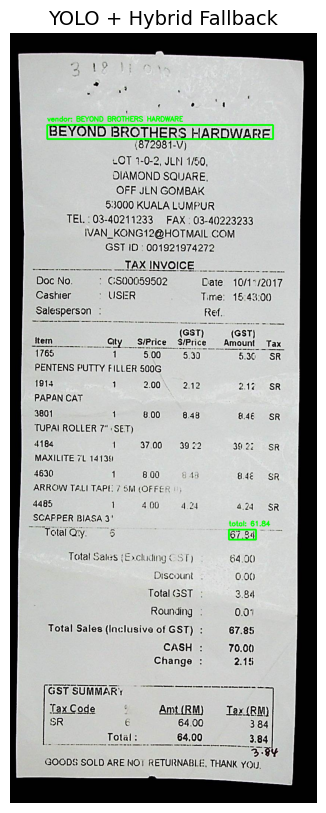


--- 🧾 EXTRACTED DATA ---
  VENDOR: BEYOND BROTHERS HARDWARE
  TOTAL: 61.84
------------------------------


In [8]:
# Run Test
test_dir = DATA_PATH / "raw/SROIE2019/test/img"
files = list(test_dir.glob("*.jpg"))[:2]
for f in files: run_scanner(f)


--- 📸 Scanning: IMG_8485 2.jpg ---
   ⚠️ Missing fields: ['vendor', 'date']. Engaging Fallback...
 Running Full Page OCR Safety Net...


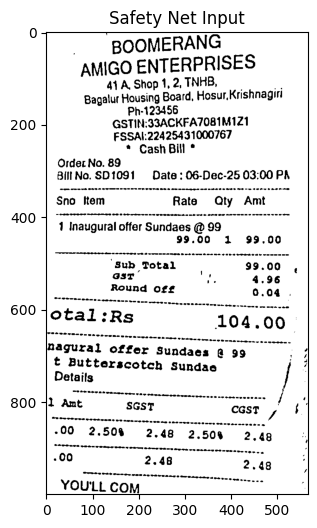

- BOOMERANG
AMIGO ENTERPRISES

414A Shop 1,2,TNHB, '
Bagalur Housing Board, Hosur, Krishnagiri
Ph-123456
GSTIN:33ACKFA7081M121
FSSAI:22425431000767
* Cash Bill °

Ordet No. 89
Bill|No. SD1091 Date : 06-Dec-25 03:00 PA

Sno Item Rate Qty Amt

1 Inaugural offer Sundaes @ 99
99.00 1 99.00

“Sub Total 99.00 ,
ost tr 4.96
. Round off 0.04
otal:Rs 104 .00

nhagural offer Sundaes @ 99
t Butterscotch Sundae
Details

1 Ant SGST

 



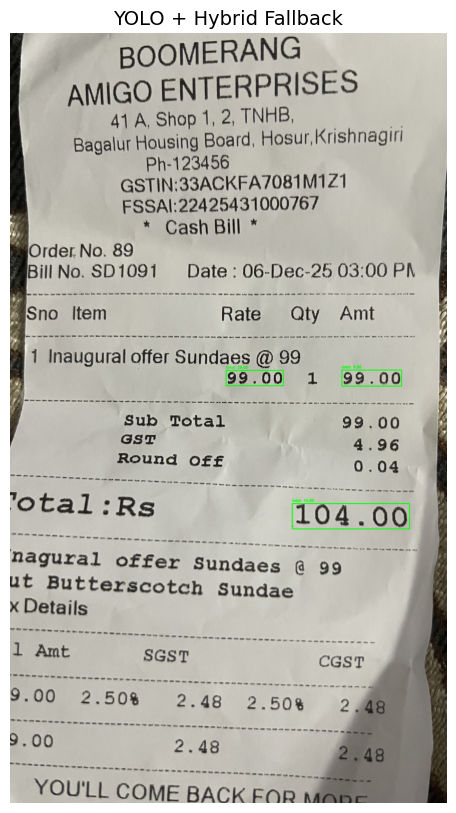


--- 🧾 EXTRACTED DATA ---
  TOTAL: 29.00
  VENDOR: - BOOMERANG
------------------------------

--- 📸 Scanning: IMG_8484 2.jpg ---
   ⚠️ Missing fields: ['vendor', 'date', 'total']. Engaging Fallback...
 Running Full Page OCR Safety Net...


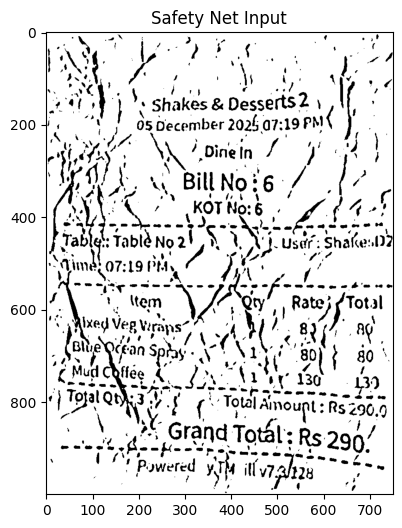

ir Shakes & . Desserts? \
05 December 2024 a7: 19 pat

‘ oe \\ iti f yo

< \s, BLN $6 / r -

Kor Nore (4-5

a aia we ‘. UsiF: Ah 02
my Lf
‘aim 07: 19t My Wh

meee ome ew ae ew wee ftw a tim ee

?

“

  
      

o

1 tem Me Fate ra
xed Venn Ae ‘ ayy!

ae a \
ud CAffee x ie AR Ne 13a 139

nbn Sate.
whaler een ee cee LT,

ri Mt {" ‘Total Amount 5 290.0

a? Grand Total’: Rs 230/

oon’ wot p ee

fr "
_ ' Powered ‘yh ill saghas —



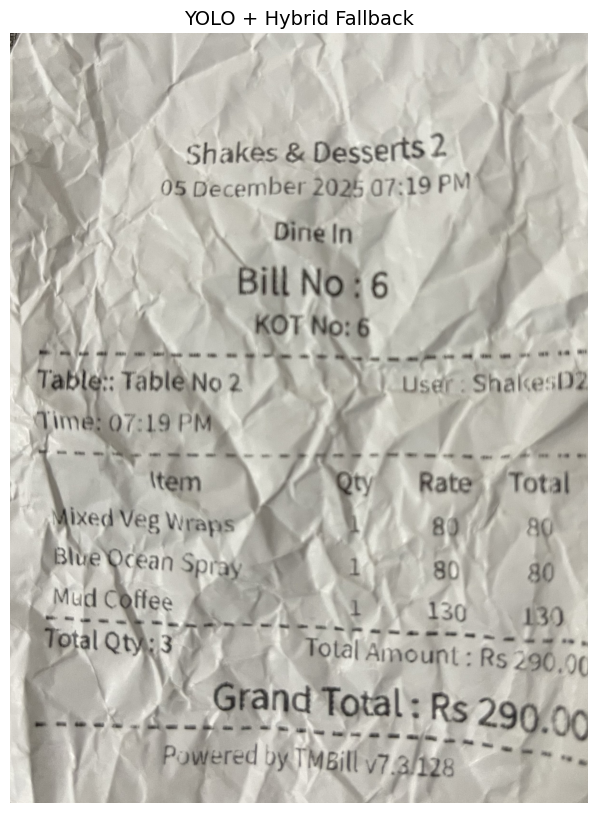


--- 🧾 EXTRACTED DATA ---
  DATE: 05 December 2024
  VENDOR: ir Shakes & . Desserts? \
------------------------------

--- 📸 Scanning: test_1.jpg ---
   ⚠️ Missing fields: ['vendor', 'date', 'total']. Engaging Fallback...
 Running Full Page OCR Safety Net...


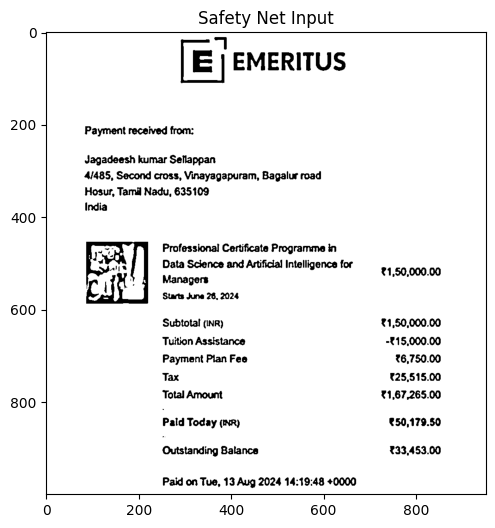

7
[E| EMERITUS

Payment received from:

Jagadeesh kumar Sellappan

4/485, Second cross, Vinayagapuram, Bagalur road
Hosur, Tami Nadu, 635109

India

Professional Certificate Programme in
Data Science and Artificial Intelligence for
Managers

Starts June 26, 2024

 

Subtotal (INR)
Tuition Assistance
Payment Plan Fee
Tax

Total Amount

Paid Today (mr)

Outstanding Balance

Paid on Tue, 13 Aug 2024 14:19:48 +0000

%1,50,000.00

%1,50,000.00
15,000.00
%6,750.00
25,515.00
%1,67,265.00

€50,179.50

233,453.00



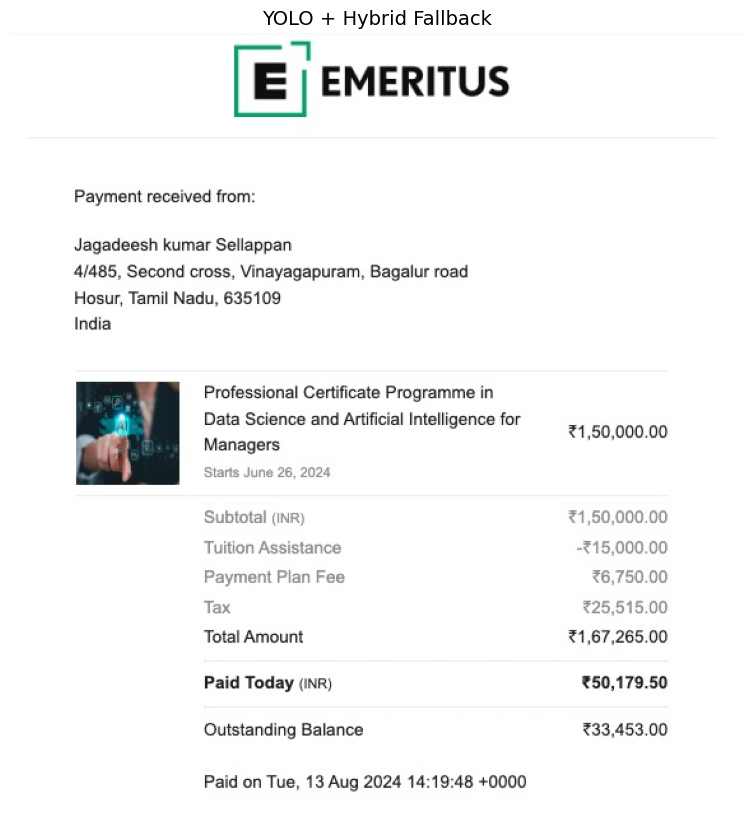


--- 🧾 EXTRACTED DATA ---
  DATE: 13 Aug 2024
  TOTAL: 233453.00
  VENDOR: [E| EMERITUS
------------------------------

--- 📸 Scanning: rapido_1.jpg ---
   ⚠️ Missing fields: ['vendor', 'date', 'total']. Engaging Fallback...
 Running Full Page OCR Safety Net...


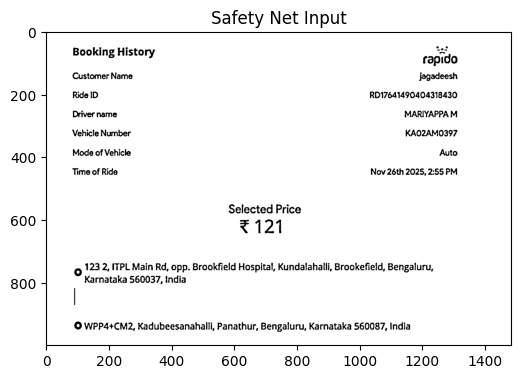

Booking History

Customer Name
Ride ID

Driver name
Vehicle Number
Mode of Vehicle
Time of Ride

Selected Price

F121

rapido
Jegadeesh

RD17641490404318430
MARIYAPPA M
KA02AM0397

Auto

Nov 26th 20285, 2:55 PM

123 2, ITPL Main Rd, opp. Brookfield Hospital, Kundalahalli, Brookefield, Bengaluru,

Karnataka 560037, India

© WPP4+CM2, Kadubeesanahalli, Panathur, Bengaluru, Karnataka 560087, India



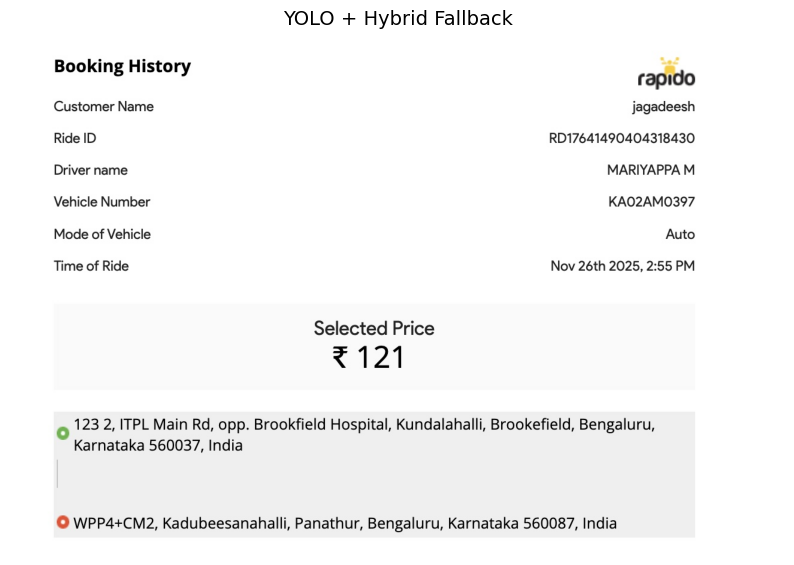


--- 🧾 EXTRACTED DATA ---
  VENDOR: Booking History
------------------------------


In [9]:
# Run Test
test_dir = DATA_PATH / "own"
files = list(test_dir.glob("*.jpg"))[:4]
for f in files: run_scanner(f)